# Import libraries

In [1]:
from __future__ import annotations
from pathlib import Path
import numpy as np
import pandas as pd


import os
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
# --- Optional: load variables via your existing parser ---
try:
    from scripts.parse_vars import parse_variables
except Exception:  # pragma: no cover
    parse_variables = None


# Load functions

In [2]:
from scripts.parse_vars import parse_variables, load_config
from scripts.helpers import map_to_color
from scripts.lower_dim import compute_pcs, attach_metadata

# Declare variables

In [3]:
PATH_VARS = Path("../../geno_simulation.txt")
R_DIRECTORY = Path("../../rstudio_geno_simulation")

# Random seed for reproducibility of the flip step
RNG_SEED = 42
rng = np.random.default_rng(RNG_SEED)

In [4]:
cfg = load_config(PATH_VARS)
G = int(cfg["G"]); L = int(cfg["L"]); c = int(cfg["c"]); k = int(cfg["k"]); M = float(cfg["M"]);

In [5]:
very_rare_threshold_L = float(cfg["very_rare_threshold_L"])
very_rare_threshold_H = float(cfg["very_rare_threshold_H"])
rare_threshold_L = float(cfg["rare_threshold_L"])
rare_threshold_H = float(cfg["rare_threshold_H"])
common_threshold_L = float(cfg["common_threshold_L"])
common_threshold_H = float(cfg["common_threshold_H"])

# Mix populations

In [6]:
path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{cfg['F_inbred']}/phenotype/"

humans_inbred = pd.read_pickle(f"{path_pheno}/humans.pkl")

path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{cfg['F_outbred']}/phenotype/"

humans_outbred = pd.read_pickle(f"{path_pheno}/humans.pkl")

In [7]:
humans_outbred

,populations,x,y,z_outbred
0,1,1,1,0
1,1,1,1,0
2,1,1,1,0
3,1,1,1,0
4,1,1,1,0
...,...,...,...,...
1995,100,10,10,0
1996,100,10,10,0
1997,100,10,10,0
1998,100,10,10,0


In [8]:
pheno = humans_outbred[['x','y','populations']].copy()
pheno['01_all_outbred'] = humans_outbred['z_outbred']
pheno['02_all_inbred'] = humans_inbred['z_inbred']
pheno['03_linear_mix'] = pheno['x'] + pheno['y']
# Sinusoidal pattern (e.g., across x)
freq_x = 3  # 3 full sine cycles across the x-dimension
freq_y = 2  # 2 full sine cycles across the y-dimension

pheno['04_sine_x_mix'] = np.round(np.sin(pheno['x'] * freq_x * np.pi / k), 2)
pheno['05_sine_y_mix'] = np.round(np.sin(pheno['y'] * freq_y * np.pi / k), 2)
# Interaction term (e.g., product of x and y)
pheno['06_sine_x_y_mix'] = np.round(pheno['04_sine_x_mix'] + pheno['05_sine_y_mix'],2)
n = int(k - k//3)
pheno['07_discrete_mix'] = ((pheno['x'] == n) & (pheno['y'] == n)).astype(int)



from sklearn.preprocessing import MinMaxScaler

# Define a function to scale to [-1, 1]
def scale_minus1_to_1(series):
    scaler = MinMaxScaler(feature_range=(0, 1))
    return scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

# Apply scaling to all relevant phenotypes
for col in ['03_linear_mix', '04_sine_x_mix', '05_sine_y_mix', '06_sine_x_y_mix', '07_discrete_mix']:
    pheno[col] = scale_minus1_to_1(pheno[col])


In [9]:
mixes = ['01_all_outbred', '02_all_inbred', '03_linear_mix', '04_sine_x_mix', '05_sine_y_mix', '06_sine_x_y_mix', '07_discrete_mix']

In [10]:
humans = pheno.copy()

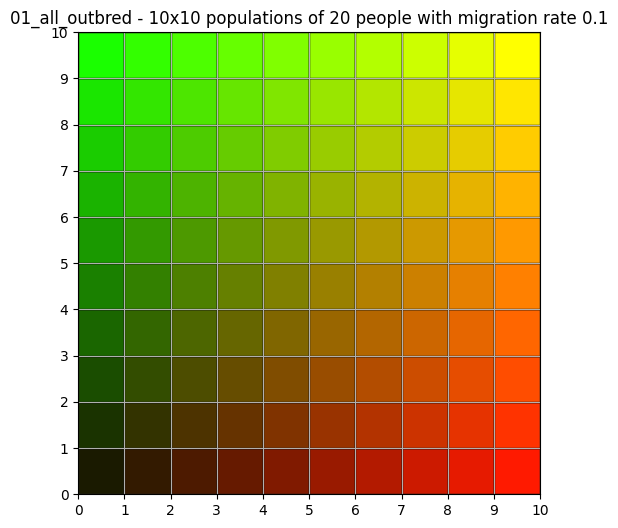

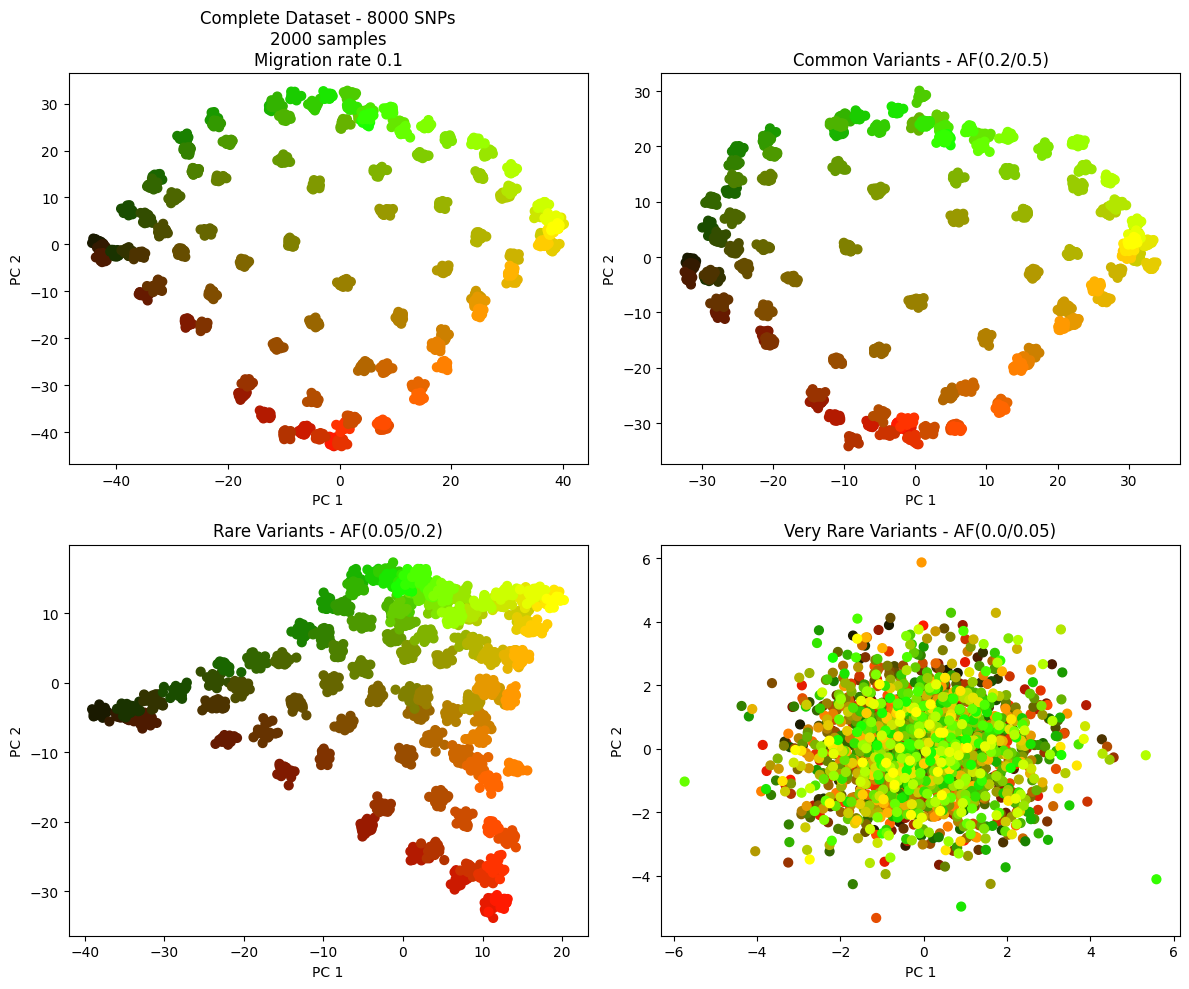

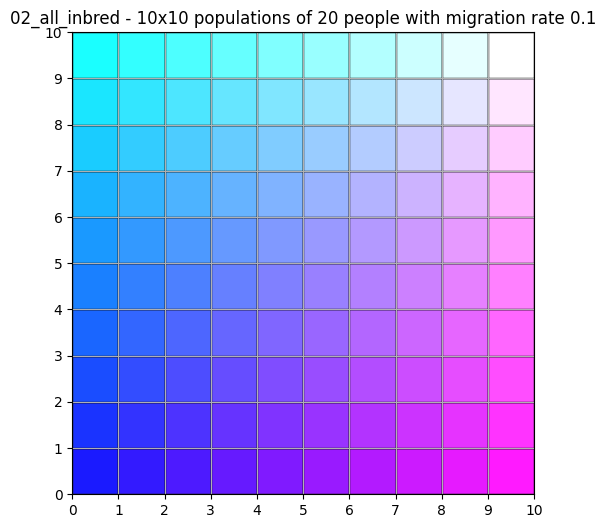

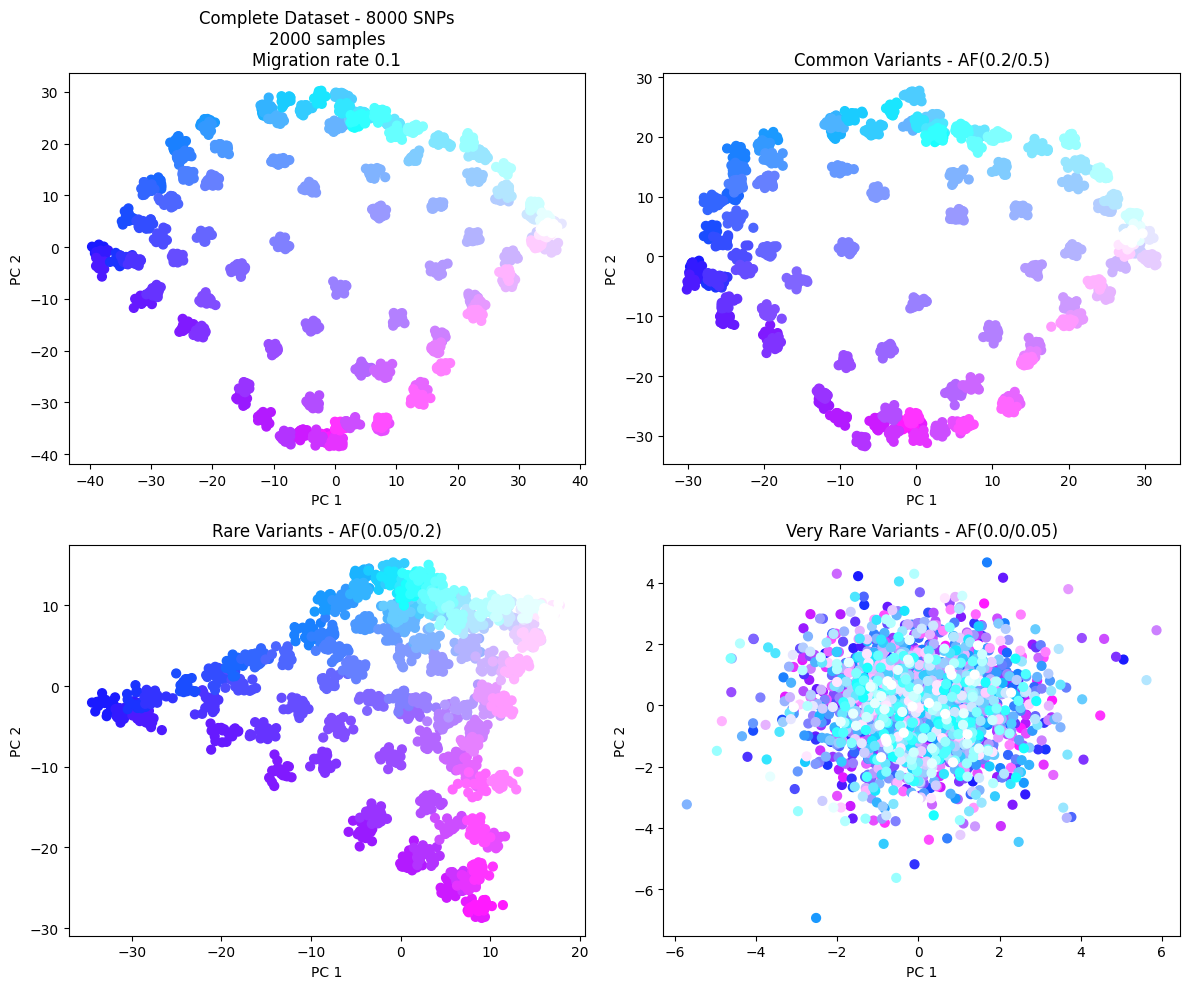

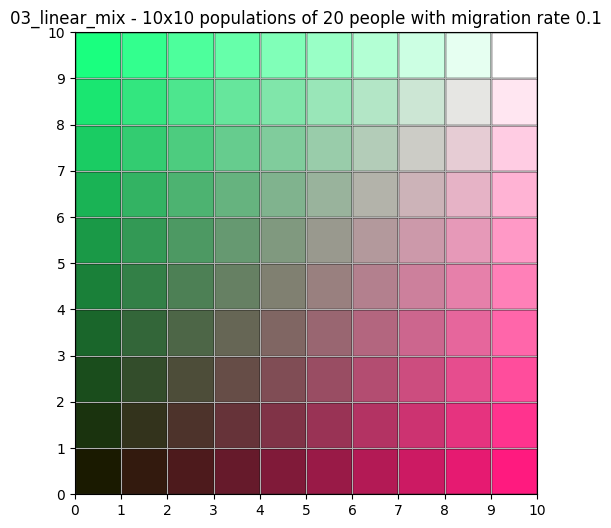

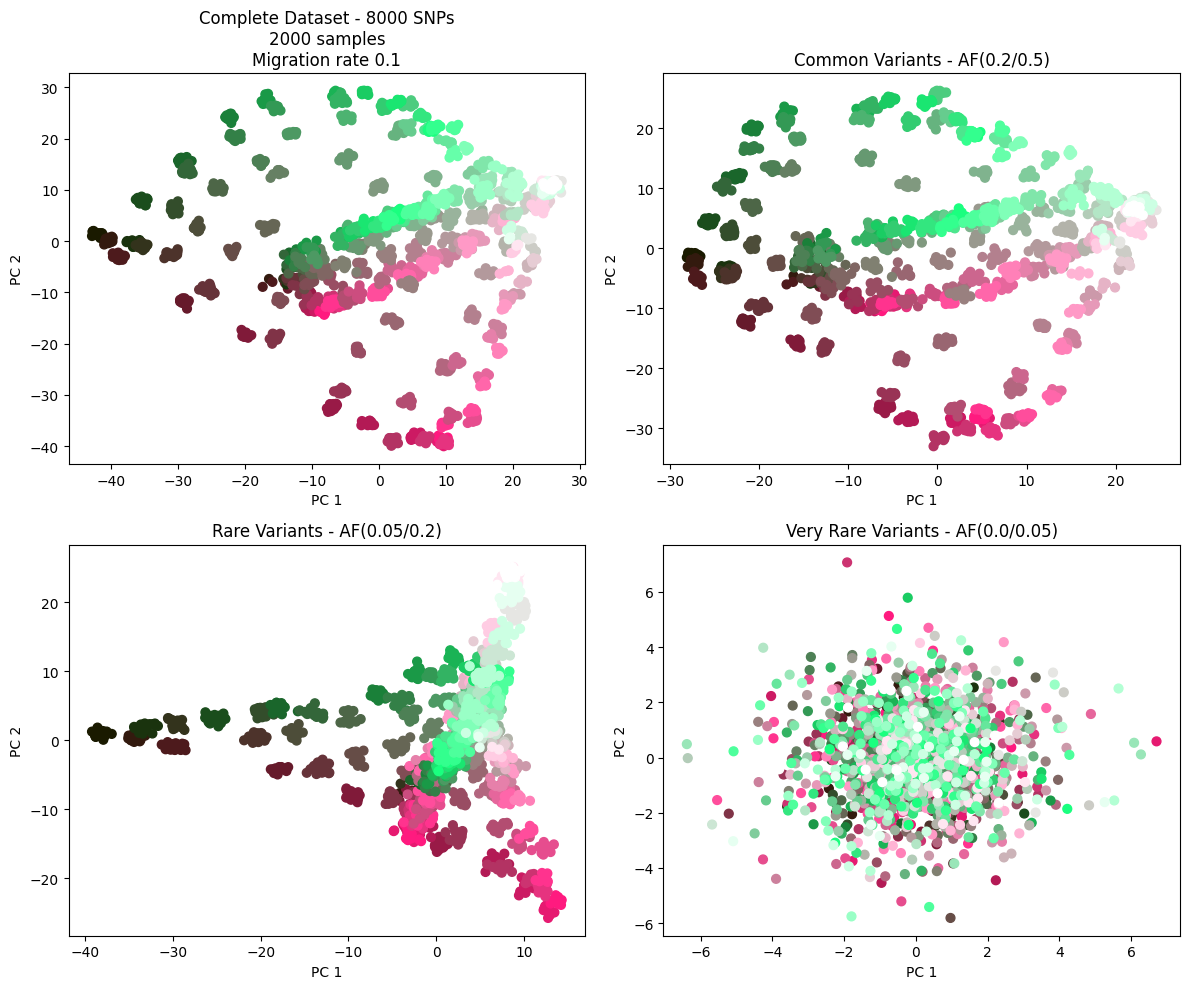

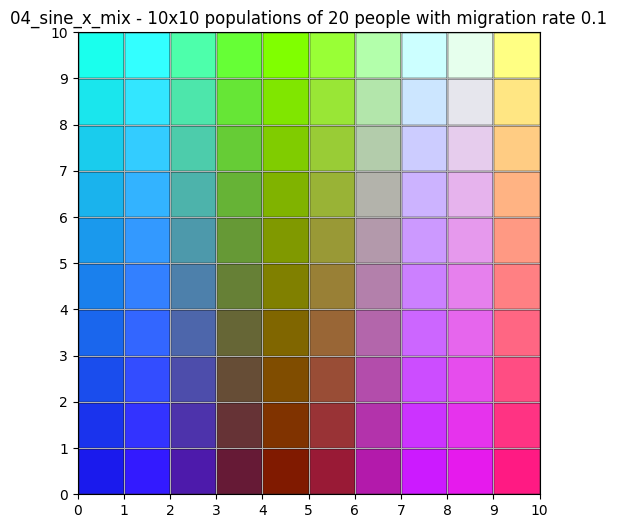

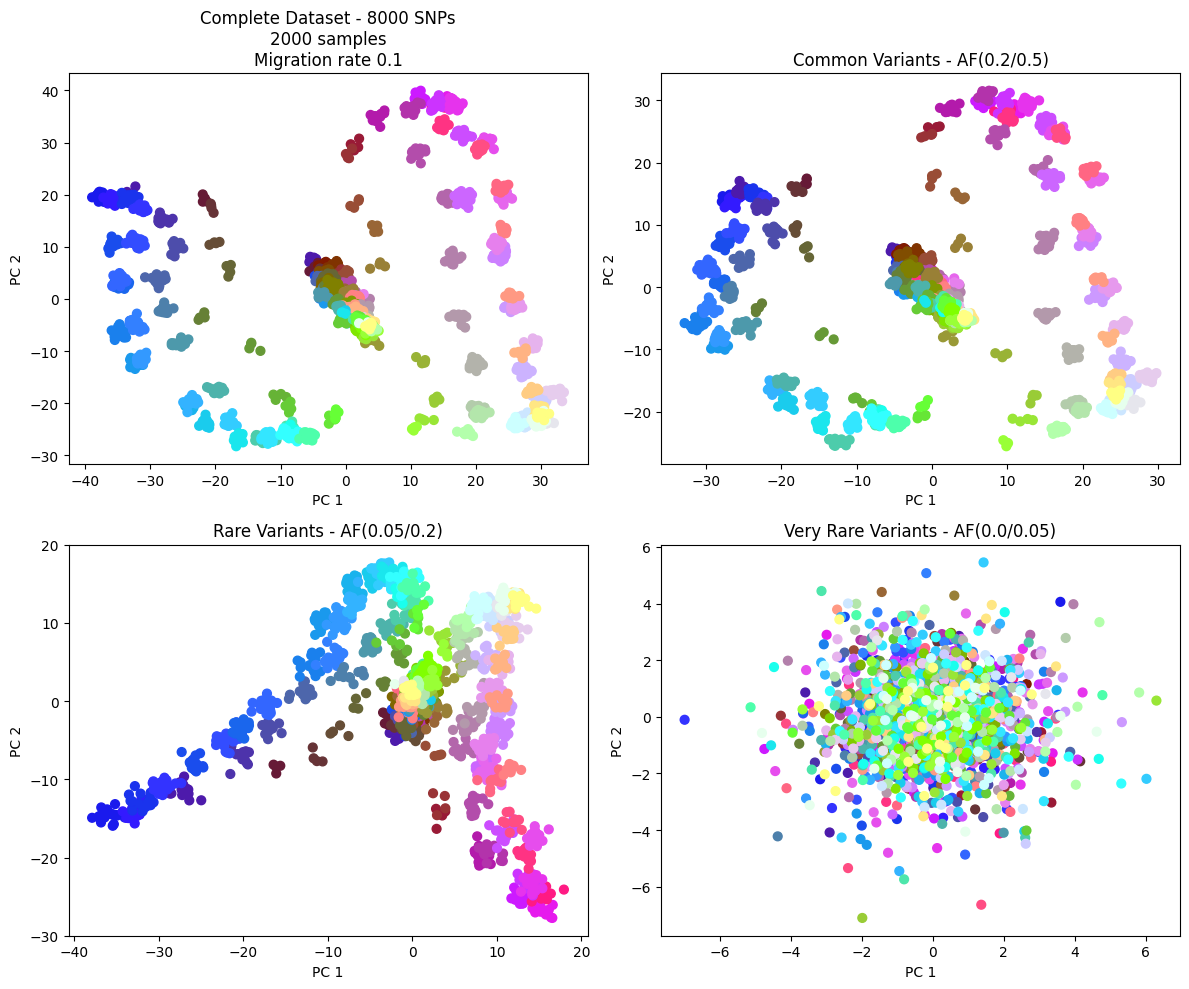

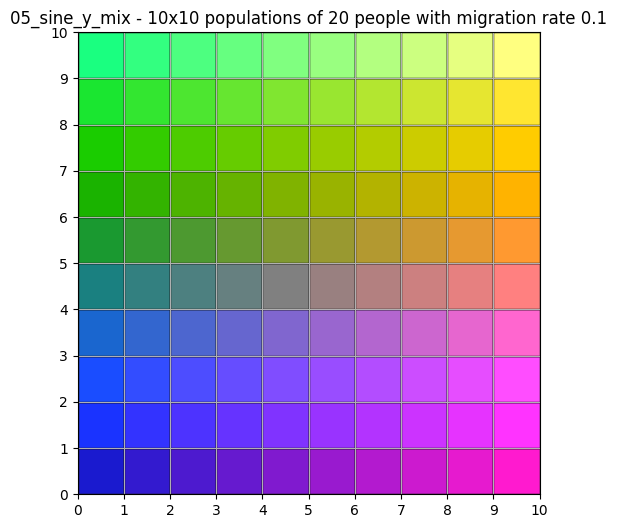

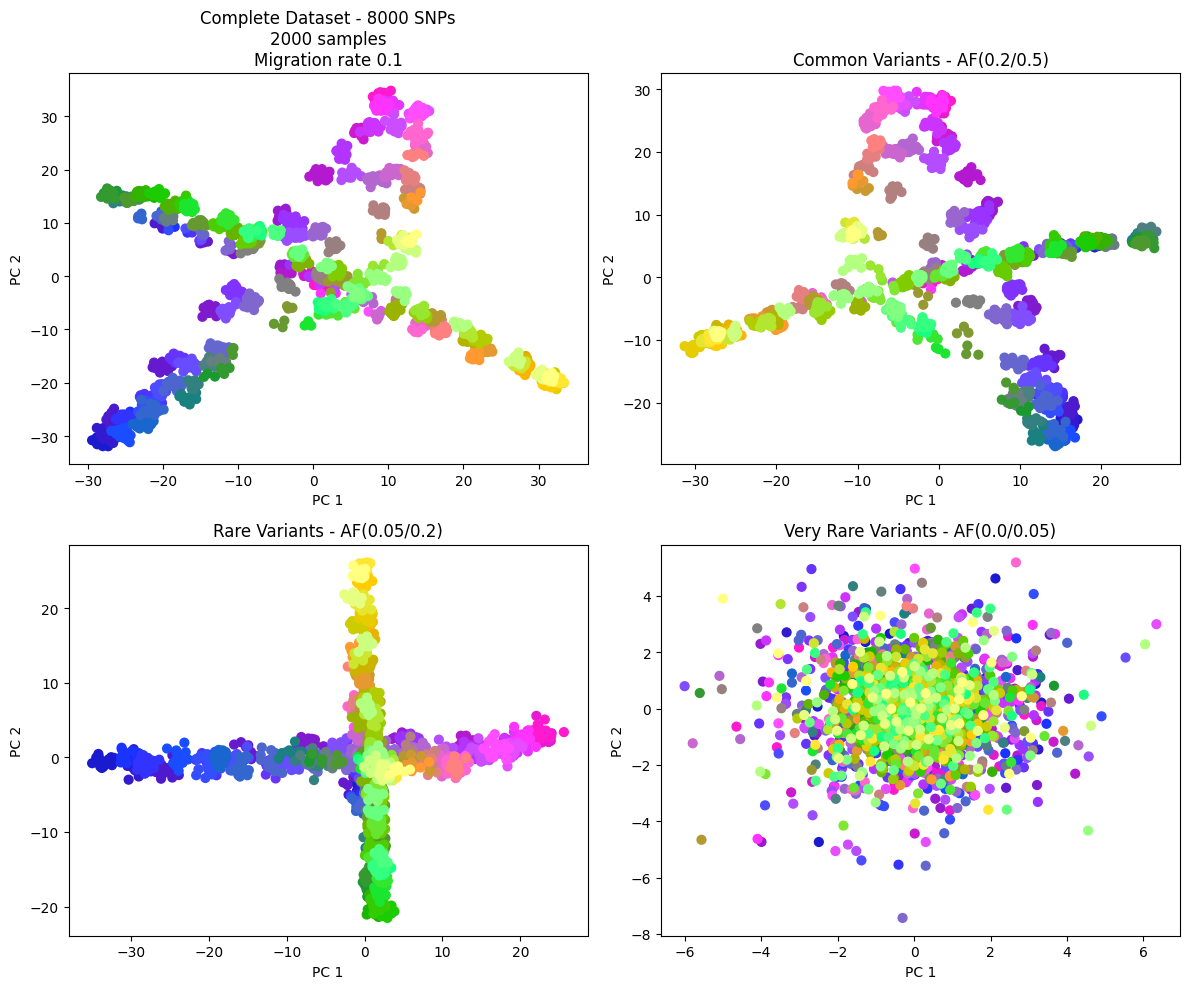

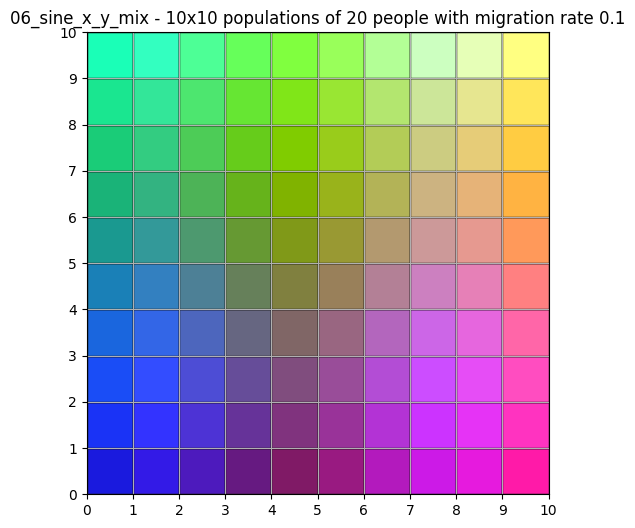

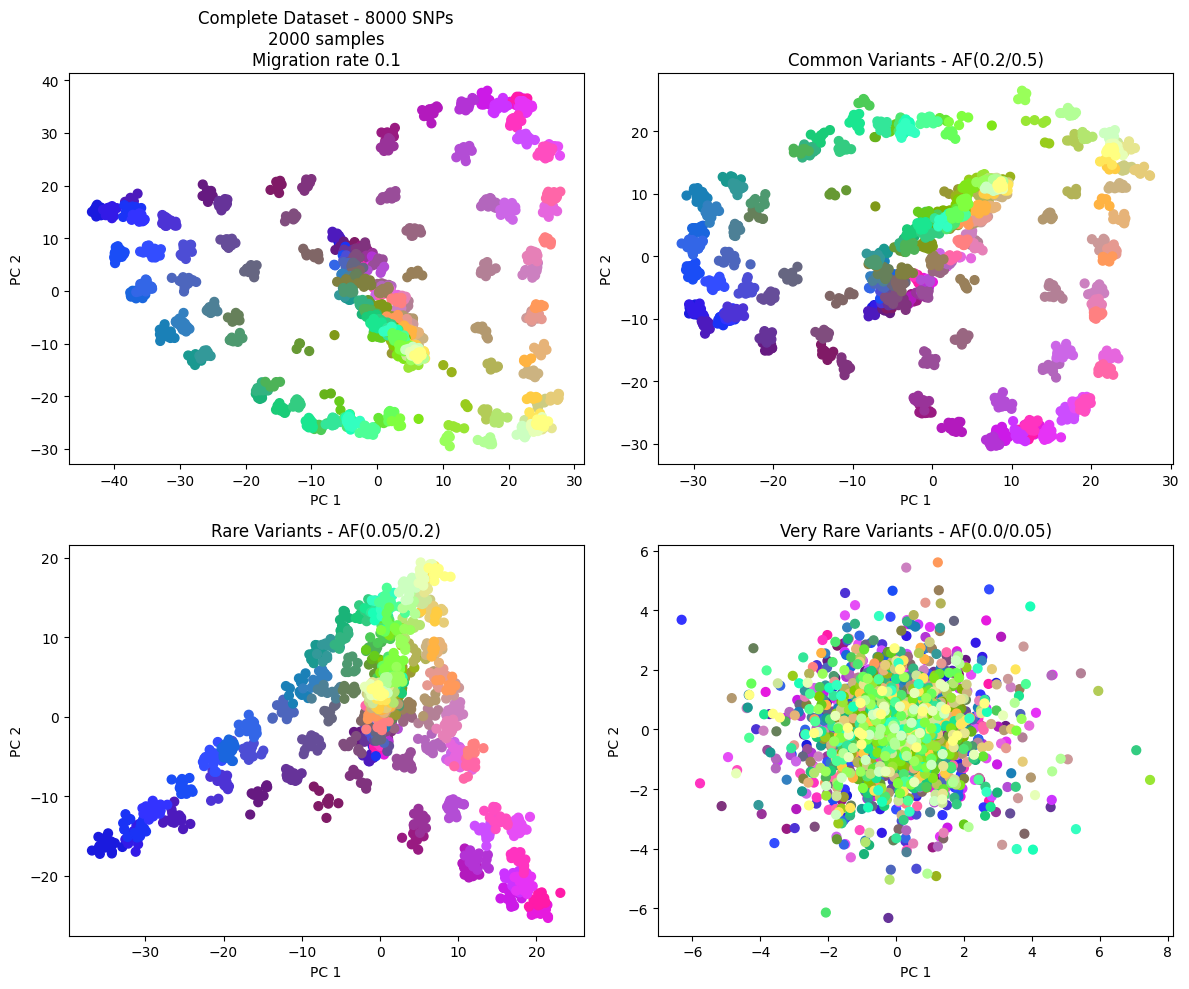

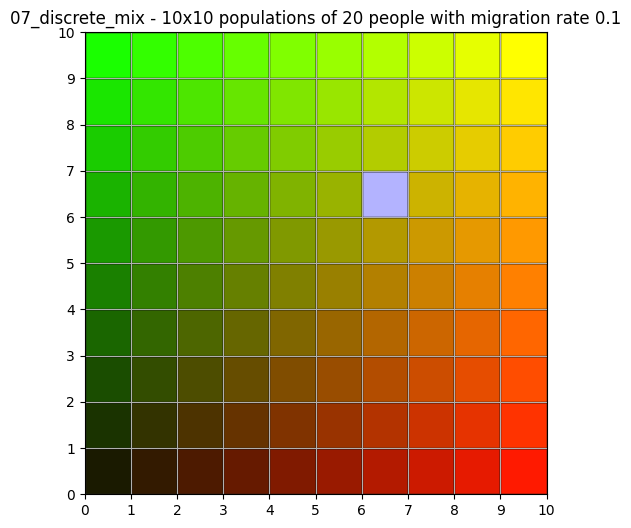

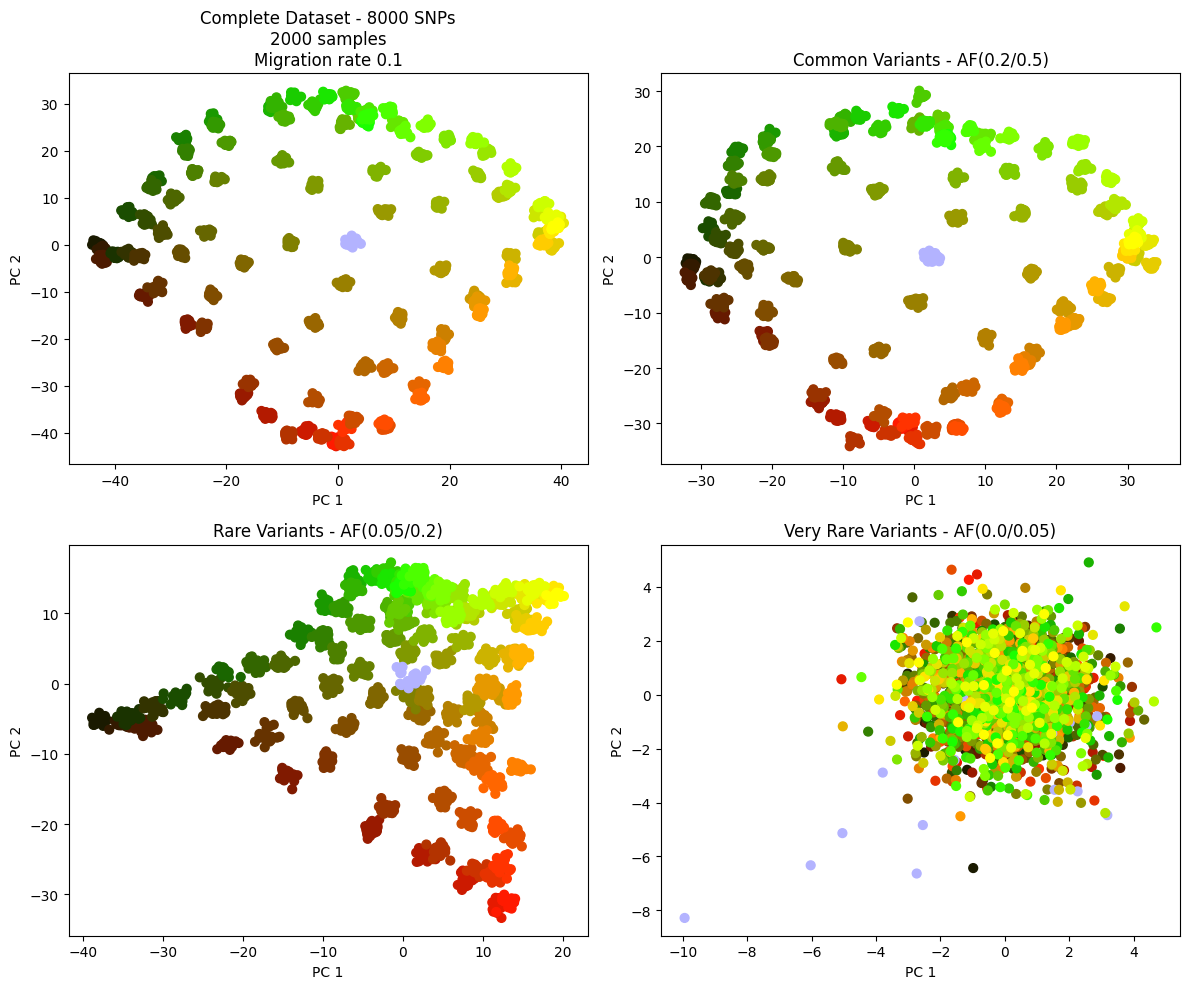

In [11]:
inbred =  pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{cfg['F_inbred']}/genotype/complete.pkl")
inbred_og_cols = inbred.columns
outbred = pd.read_pickle(f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_F{cfg['F_outbred']}/genotype/complete.pkl")

def clean_col(col):
    if col == "pop":
        return col
    if "_MAF_" in col:
        return col.split("_MAF_")[0]  # keep only prefix
    return col  # if any other case appears

inbred.columns = [clean_col(c) for c in inbred.columns]
outbred.columns = inbred.columns

inbred['pops'] = pheno['populations']
outbred['pops'] = pheno['populations']

for mix in mixes:
    fig, ax = plt.subplots(figsize=(6, 6))
    for i in range(k):
        for j in range(k):
            # pick the row for this grid cell
            row = humans[(humans['x'] == i+1) & (humans['y'] == j+1)].iloc[0]
            # compute ONE color for this cell
            cell_color = map_to_color(row['x'], row['y'], row[mix], humans, mix)
    
            ax.add_patch(plt.Rectangle((i, j), 1, 1, facecolor=cell_color, edgecolor='black'))
    
    ax.set_xlim(0, k)
    ax.set_ylim(0, k)
    ax.set_aspect('equal')
    ax.set_xticks(range(k + 1))
    ax.set_yticks(range(k + 1))
    ax.grid(True)
    plt.title(f"{mix} - {k}x{k} populations of {c} people with migration rate {M}")
    plt.show()



    mixed_genotype = []
    for pop in inbred['pops'].unique():
        inbred_pop = inbred[inbred['pops'] == pop]
        nr_people_inbred = inbred_pop.shape[0]
        outbred_pop = outbred[outbred['pops'] == pop]
        humans_pop = humans[humans['populations']==pop]
        ratio = humans_pop[mix].mean()
        inbred_to_select = int(nr_people_inbred*ratio)
        outbred_to_select = int(nr_people_inbred-inbred_to_select)
        sampled_inbred = inbred_pop.sample(n=inbred_to_select, random_state=42)
        sampled_inbred['breed'] = "inbred"
        sampled_outbred = outbred_pop.sample(n=outbred_to_select, random_state=42)
        sampled_outbred['breed'] = "outbred"
    
        combined_df = pd.concat([sampled_inbred, sampled_outbred], ignore_index=True)
         
        combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)
        mixed_genotype.append(combined_df)
    
    mixed_genotype = pd.concat(mixed_genotype, ignore_index=True)
    humans['breed'] = list(mixed_genotype['breed'])
    mixed_genotype = mixed_genotype.drop(columns = ['pops','breed'])
    
    path_geno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_mixed_{mix}/genotype"
    path_pheno = f"simulation_data/G{G}_L{L}_c{c}_k{k}_M{M}_mixed_{mix}/phenotype/"
    os.makedirs(path_geno, exist_ok = True)
    os.makedirs(path_pheno,exist_ok=True)
    mixed_genotype.to_pickle(f"{path_geno}/complete.pkl")
    humans[['populations', 'x','y',mix,'breed']].to_pickle(f"{path_pheno}/humans.pkl")
    
    mixed_genotype.columns = inbred_og_cols
    # Categorize columns based on allele frequency
    # Initialize lists to hold the DataFrames
    very_rare_cols = []
    rare_cols = []
    common_cols = []
    for col in mixed_genotype.columns:
        af_value = float(col.split('_')[3])
        if very_rare_threshold_L < af_value <= very_rare_threshold_H:
            very_rare_cols.append(mixed_genotype[[col]])
        elif rare_threshold_L < af_value <= rare_threshold_H:
            rare_cols.append(mixed_genotype[[col]])
        elif common_threshold_L < af_value <= common_threshold_H:
            common_cols.append(mixed_genotype[[col]])
    
    # Concatenate all collected DataFrames at once
    very_rare = pd.concat(very_rare_cols, axis=1) if very_rare_cols else pd.DataFrame()
    rare = pd.concat(rare_cols, axis=1) if rare_cols else pd.DataFrame()
    common = pd.concat(common_cols, axis=1) if common_cols else pd.DataFrame()
    
    # Concatenate the final DataFrame
    complete = pd.concat([common, rare, very_rare], axis=1)
    PC_complete  = compute_pcs(complete,  prefix="PC")
    PC_common    = compute_pcs(common,    prefix="PC")
    PC_rare      = compute_pcs(rare,      prefix="PC")
    PC_veryrare  = compute_pcs(very_rare, prefix="PC")
    
    # --- Attach metadata in one pass, with index alignment
    to_have_columns = ['populations', 'x', 'y', 'populations']  # (typo fixed)
    
    PC_complete  = attach_metadata(PC_complete,  humans, to_have_columns)
    PC_common    = attach_metadata(PC_common,    humans, to_have_columns)
    PC_rare      = attach_metadata(PC_rare,      humans, to_have_columns)
    PC_veryrare  = attach_metadata(PC_veryrare,  humans, to_have_columns)
    
    number_of_snps = complete.shape[1]
    number_of_individuals = complete.shape[0]
    
    # Generate color mapping for the 'humans' DataFrame
    colors_inbred = [map_to_color(x, y, z, humans, mix) for x, y, z in zip(humans['x'], humans['y'], humans[mix])]
    # Create a figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    dataframes = [PC_complete, PC_common, PC_rare, PC_veryrare]
    titles = [f"Complete Dataset - {number_of_snps} SNPs\n{number_of_individuals} samples\nMigration rate {M}",
              f"Common Variants - AF({common_threshold_L}/{common_threshold_H})", 
              f"Rare Variants - AF({rare_threshold_L}/{rare_threshold_H})", 
              f"Very Rare Variants - AF({very_rare_threshold_L}/{very_rare_threshold_H})"]
    
    # Iterate through dataframes, axes, and titles
    for df, ax, title in zip(dataframes, axes.flatten(), titles):
        # Count the unique values in the 'populations' column
        unique_populations = df['populations'].nunique()
        # Plotting the principal components with colors
        ax.scatter(x=df['PC1'], y=df['PC2'], c=colors_inbred, s=40)
        
        ax.set_title(title)  # Set the title for the current subplot
        ax.set_xlabel('PC 1')
        ax.set_ylabel('PC 2')
        ax.legend([],[], frameon=False) # This hides the legend
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plots
    plt.show()
    plt.close()